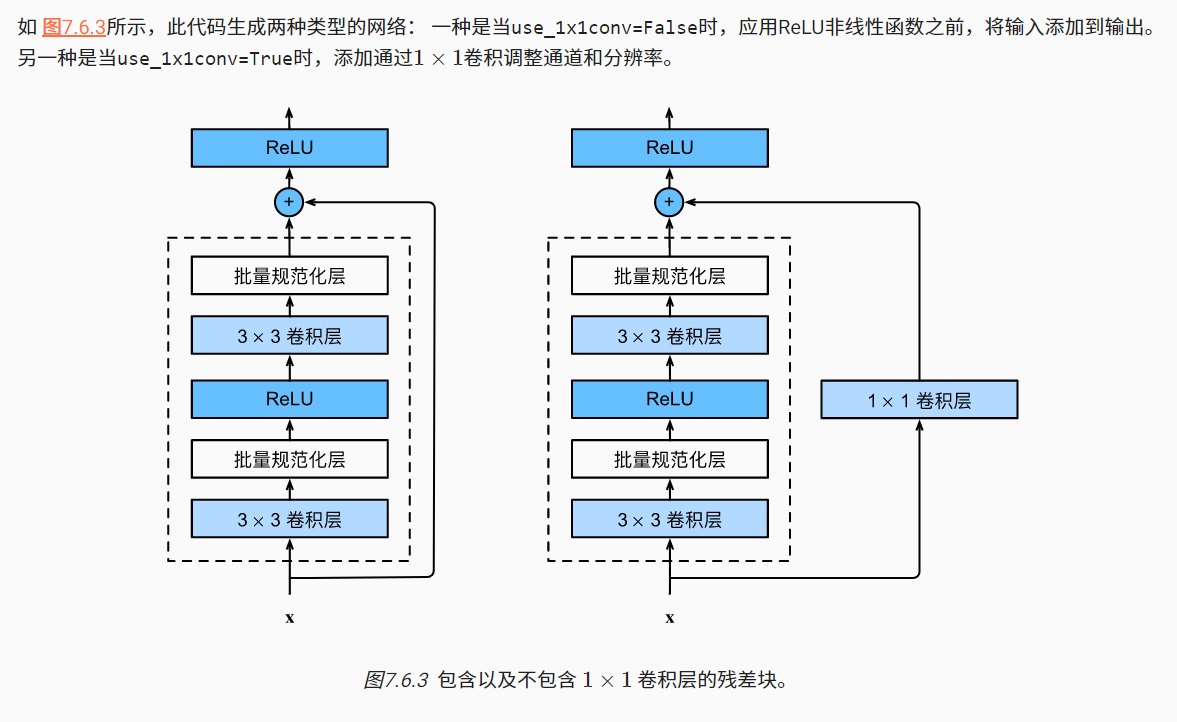

In [1]:
!pip install d2l
!pip install matplotlib==3.0.0
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Residual(nn.Module):  
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 82 kB 567 kB/s 
     |████████████████████████████████| 11.2 MB 8.5 MB/s 
     |████████████████████████████████| 61 kB 6.6 MB/s 
     |████████████████████████████████| 15.7 MB 54.5 MB/s 
     |████████████████████████████████| 9.9 MB 35.8 MB/s 
     |████████████████████████████████| 944 kB 44.4 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 4.4 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires matplotlib!=3.0.0,>=2.0.2, but you have matplotlib 3.0.0 which is incompatible.
scikit-image 0.18.3 requires matplotlib!=3.0.0,>=2.0.0, but you have matplotlib 3.0.0 which is incompatible.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.0 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.0 which is incompatible.
d2l 0.17.5 requires matplotlib==3.5.1, but you have matplotlib 3.0.0 which is incompatible.
albu

In [2]:
# 相比于GoogLeNet，ResNet每个卷积层后增加了批量规范化层
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [3]:
# ResNet则使用4个由残差块组成的模块，每个模块使用若干个（此处是两个）同样输出通道数的残差块。 
# 第一个模块的通道数同输入通道数一致。 由于之前已经使用了步幅为2的最大汇聚层，所以无须减小高和宽。 
# 之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高和宽减半。

def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            # 做高宽减半操作
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels)) # 做通道数和高宽都不变的操作
    return blk

In [4]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True)) # 因为b1中做了两次高宽减半，所以在b2中不做减半操作
b3 = nn.Sequential(*resnet_block(64, 128, 2)) # b2，b3，b4中的第一个残差块做高宽减半，通道数翻倍
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [5]:
# 在ResNet中加入全局平均汇聚层，以及全连接层输出
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [6]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


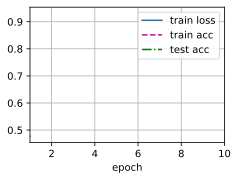

In [ ]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())